In [14]:
import torch
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
import math

In [15]:
# deactivate grad
torch.set_grad_enabled(False)

# Data

Create a dataset of 1000 points with label 0 if outside the disk of radius 1/√2π and 1 inside

In [16]:
def generate_disc_set(nb):
    input = Tensor(nb, 2).uniform_(-1, 1)
    target = 1-input.pow(2).sum(1).sub(2 / math.pi).sign().add(1).div(2).long()
    return input, target

In [17]:
def plot_dataset(train_input,train_target):
    Label=train_target.view(-1).float() # 1- to display the other label
    x1=(train_input.narrow(1,0,1).view(-1)*Label).numpy();
    y1=(train_input.narrow(1,1,1).view(-1)*Label).numpy();
    x0=(train_input.narrow(1,0,1).view(-1)*(1-Label)).numpy();
    y0=(train_input.narrow(1,1,1).view(-1)*(1-Label)).numpy();
    plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

    subplot=plt.subplot(1,2,1)
    axes = plt.gca();
    plt.title("Showing the dataset with the label 1");
    subplot.plot(x1,y1,'go');
    axes.set_xlim([-2,2]);
    axes.set_ylim([-2,2]);
    subplot=plt.subplot(1,2,2)
    axes = plt.gca();
    plt.title("Showing the dataset with the label 0");
    subplot.plot(x0,y0,'go');
    axes.set_xlim([-2,2]);
    axes.set_ylim([-2,2]);
    return subplot

In [18]:
train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

mean, std = train_input.mean(), train_input.std()

train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)

tensor([[ 0.5940,  1.0819],
        [ 1.6006, -1.5818],
        [ 1.1679, -1.4071],
        ...,
        [-0.9773,  1.6951],
        [ 1.2761, -1.2858],
        [-0.5964,  0.2228]])

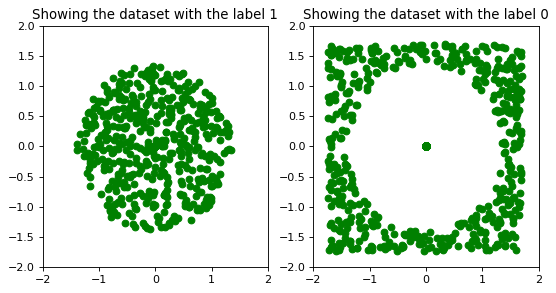

In [19]:
plot_dataset(train_input, train_target)

# Utils

In [20]:
def convert_to_one_hot_labels(input, target):
    tmp = input.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

In [21]:
def compute_nb_errors(model, data_input, data_target,mini_batch_size):
    nb_data_errors = 0
    for b in range(0, data_input.size(0), 1):
        output = model.forward(data_input.narrow(0, b, mini_batch_size))
        _, predicted_classes = torch.max(output.data, 1)
        for k in range(mini_batch_size):
            if data_target.data[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

# Module Class

In [22]:
# heritage module definition
class Module(object):
    def __init__(self):
        super().__init__()
        self.lr = 0
    def forward(self, *input) :
        raise NotImplementedError
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
    def param(self):
        return []

# activation functions

In [23]:
# Relu activation function
class ReLu(Module):
    def __init__(self ):
        super().__init__()
        self.save = 0;
    def forward(self, x):
        y = x.clamp(min=0)
        self.save = x;
        return y
    def backward(self, x):
        y = self.save > 0
        return y.float()*x
    def print(self):
        return

# tanh activation function
class Tanh(Module):
    def __init__(self, ):
        super().__init__()        
    def forward(self,x):
        y = (x.exp() - (-x).exp()) / ( x.exp() +  (-x).exp())
        return y
    def backward(self,x):
        y = 4*(x.exp() + x.mul(-1).exp()).pow(-2)
        return y
    def print(self):
        return

# MSE loss function

In [24]:
#MSE Loss implementation 
class LossMSE(Module):
    def __init__(self, ):
        super().__init__()
    def loss(self,y,y_pred):
        loss = (y_pred - y).pow(2).sum()
        return loss
    def grad(self,y,y_pred):
        return 2*(y_pred-y)

# Layers implementation

In [25]:
# Linear layer
class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.x = torch.zeros(out_features)        
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.rand(size=(self.in_features,self.out_features))
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias = torch.rand(self.out_features)
        self.bias.data.uniform_(-stdv, stdv)

    def print(self):
            print([self.weight.size(0),self.weight.size(1)])
            print(self.x.size(0))
    def print_weight(self):
        print(self.weight) 
    def update(self, grad):
        lr = self.lr
        self.weight = self.weight - lr*self.x.t().mm(grad) 
        self.bias = self.bias - lr*grad*1
    
    def backward(self, grad):
        b = grad.mm(self.weight.t())
        self.update(grad)
        return b
    def forward(self, x):
        self.x = x
        return x.mm(self.weight)+self.bias;
    def set_Lr(self, lr):
        self.lr = lr
        return

# Sequential architecture

In [26]:
# Sequential architecture
class Sequential(Module):
    def __init__(self, param , loss):
        super().__init__()
        self.model = (param)
        self.loss = loss
    def forward(self, x):
        for _object in self.model:
            x = _object.forward(x)
        return x
    
    def backward(self, y, y_pred):
        Loss=self.loss.loss(y, y_pred)
        grad_pred = self.loss.grad(y, y_pred)
        for _object in reversed(self.model):
            grad_pred = _object.backward(grad_pred)
        return Loss
    def print(self):
        for _object in (self.model):
            _object.print()
    def set_Lr(self, lr=0):
        for _object in self.model:
            if isinstance(_object, Linear):
                _object.set_Lr(lr)

# Training

In [32]:
nb_epochs=400
mini_batch_size=1
Model = Sequential([Linear(2,128),ReLu(),Linear(128,2),ReLu()], LossMSE()) #Building the model and linking the loss
Model.set_Lr(0.01) #Setting the learning rate

#Print Parameters of the model
Model.print() 
print("Before training, Train Error: {:.4f}%, Test Error: {:.4f}%".format(compute_nb_errors(Model,train_input,train_target,mini_batch_size)/train_input.size(0)*100,compute_nb_errors(Model,test_input, test_target,mini_batch_size)/test_input.size(0)*100))

train_target_one_hot= convert_to_one_hot_labels(train_input,train_target)
History_Loss=[]
for epochs in range(0,nb_epochs):
    Sum_Loss=0
    for b in range(0, train_input.size(0), 1):
        output = Model.forward(train_input.narrow(0, b, 1))
        Loss= Model.backward(train_target_one_hot.narrow(0, b, 1),output)
        Sum_Loss=Sum_Loss+Loss.item()
    History_Loss.append(Sum_Loss)  
    if epochs % 30 == 0:
        print("Epoch: {}, Train Error: {:.4f}%, Test Error: {:.4f}%, Loss  {:.4f}".format(epochs+1,compute_nb_errors(Model,train_input, train_target,1)/train_input.size(0)*100,compute_nb_errors(Model,test_input, test_target,1)/test_input.size(0)*100,Sum_Loss))

        
print("After training, Train Error: {:.4f}%, Test Error: {:.4f}%, Loss  {:.4f}".format(compute_nb_errors(Model,train_input,train_target,mini_batch_size)/train_input.size(0)*100,compute_nb_errors(Model,test_input, test_target,mini_batch_size)/test_input.size(0)*100,Sum_Loss))

[2, 128]
128
[128, 2]
2
Before training, Train Error: 49.9000%, Test Error: 47.7000%
Epoch: 1, Train Error: 23.0000%, Test Error: 21.5000%, Loss  620.7658
Epoch: 31, Train Error: 18.4000%, Test Error: 16.5000%, Loss  555.8050
Epoch: 61, Train Error: 17.2000%, Test Error: 15.4000%, Loss  547.2048
Epoch: 91, Train Error: 15.7000%, Test Error: 13.5000%, Loss  539.9020
Epoch: 121, Train Error: 13.0000%, Test Error: 12.0000%, Loss  535.4514
Epoch: 151, Train Error: 11.8000%, Test Error: 11.2000%, Loss  533.0304
Epoch: 181, Train Error: 11.2000%, Test Error: 10.6000%, Loss  531.4033
Epoch: 211, Train Error: 10.5000%, Test Error: 10.5000%, Loss  528.8290
Epoch: 241, Train Error: 9.9000%, Test Error: 9.8000%, Loss  528.0747
Epoch: 271, Train Error: 9.6000%, Test Error: 9.5000%, Loss  527.6661
Epoch: 301, Train Error: 9.1000%, Test Error: 9.4000%, Loss  527.1477
Epoch: 331, Train Error: 8.9000%, Test Error: 9.3000%, Loss  526.8560
Epoch: 361, Train Error: 9.1000%, Test Error: 9.4000%, Loss  526